In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader

In [2]:
from skimage import io
import skimage

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
import os

In [5]:
num_classes=2

batch_size=20

In [6]:
from torch.utils.data import Dataset
import pandas as pd

class JSRTdataset(Dataset):
  def __init__(self,csv_file,root_dir,transform=None):
    self.annotations=pd.read_csv(csv_file).drop("Unnamed: 0",axis=1)
    self.root_dir=root_dir
    self.transform=transform
  def __len__(self):
    return len(self.annotations)

  def __getitem__(self,index):
    img_path=os.path.join(self.root_dir,self.annotations.iloc[index,0])
    image=io.imread(img_path)
    image=skimage.color.gray2rgb(image)
    y_label=torch.tensor(self.annotations.iloc[index,1])
    if not torch.is_tensor(image):
        image=torchvision.transforms.functional.to_tensor(image)    
    if self.transform:
      '''if not torch.is_tensor(image):
        image=torchvision.transforms.functional.to_tensor(image)'''
      image=self.transform(image)
      '''image=torchvision.transforms.functional.resize(img=image,size=[255,255])
      image=torchvision.transforms.functional.normalize(tensor=image,mean=0.5,std=0.5)'''
    return (image,y_label)




In [7]:
train_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/train_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images")

test_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/test_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images")

train_loader=DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

In [8]:
# Normalisation
num_pixels_train=len(train_set)*2048*2048

total_sum=0
for batch in train_loader: total_sum += batch[0].sum()
mean = total_sum/num_pixels_train

sum_of_squared_error = 0
for batch in train_loader: sum_of_squared_error += ((batch[0]-mean).pow(2)).sum()
std = torch.sqrt(sum_of_squared_error/num_pixels_train)

print(mean,std)

tensor(1.7849) tensor(2.1148)


In [9]:
transformations = transforms.Compose([
    transforms.Resize(225),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=mean, std=std)
])


In [10]:
train_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/train_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images",transform=transformations)

test_set=JSRTdataset(csv_file="/content/drive/MyDrive/Colab Notebooks/test_new.csv",root_dir="/content/drive/MyDrive/Colab Notebooks/images",transform=transformations)

train_loader=DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)

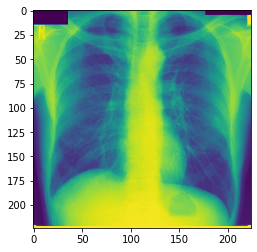

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
for images , labels in train_set:
  plt.imshow(images[0])
  plt.show()
  break

In [12]:
for images , labels in train_set:
  print(images.shape)
  print(images.dtype)
  break

torch.Size([3, 224, 224])
torch.float32


In [13]:
for i,data in enumerate(train_loader):
  imaged,labeld = data
  print(labeld)
  break

tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])


In [14]:
dataiter=iter(train_loader)
images,labels=dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())

torch.Size([20, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([20])
0


torch.Size([20, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([20])
1


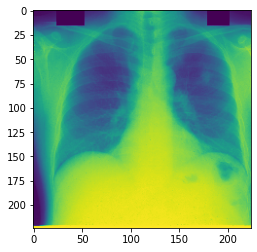

In [15]:
images,labels=dataiter.next()
print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())
plt.imshow(images[0][0])
plt.show()

torch.Size([20, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([20])
0


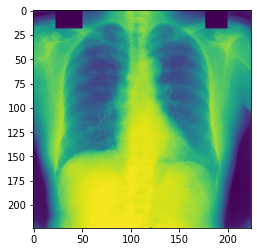

In [16]:
images,labels=dataiter.next()
print(images.shape)
print(images[0].shape)
print(labels.shape)
print(labels[0].item())
plt.imshow(images[0][0])
plt.show()

In [17]:
#model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
   # in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [19]:
model=model.to(device)

In [20]:
def double_conv(in_channels=3, out_channels=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class=2):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

In [21]:
from torchsummary import summary
model = UNet(6)
model = model.to(device)

#summary(model, input_size=(3, 224, 224))
model(images.to(device)).shape

torch.Size([20, 6, 224, 224])

In [22]:
class LeNet_for_1channel(nn.Module):
  def __init__(self):
    super(LeNet_for_1channel,self).__init__()
    self.cnn_model = nn.Sequential(
        nn.Conv2d(6,6,5,padding=(1,1),stride=(4,4)),   # (40,1,244,244)-->(40,6,60,60)
        nn.ReLU(inplace=True),                         #nn.Tanh(),
        nn.AvgPool2d(2,stride=2),                      # (40,6,60,60) --> (20,6,30,30)
        nn.Conv2d(6,16,3,padding=(1,1),stride=(2,2)),  # (20,6,30,30) --> (20,16,14,14)
        nn.ReLU(inplace=True),                         #nn.Tanh(),#self.relu = nn.ReLU(inplace=True)
        nn.AvgPool2d(2,stride=2)                       # (20,16,14,14) -->  (20,16,7,7) 
    )
    self.fc_model = nn.Sequential(
        nn.Linear(784,120),
        nn.ReLU(inplace=True),                         #nn.Tanh(),
        nn.Linear(120,84),
        nn.ReLU(inplace=True),                         #nn.Tanh(),
        nn.Linear(84,2),
        nn.Softmax()
    )
  def forward(self,x):
    x=self.cnn_model(x)
    x=x.view(x.size(0),-1)
    x=self.fc_model(x)
    return x

In [23]:
net_LeNet = LeNet_for_1channel().to(device)

In [38]:
def evaluation(dataloader):
  total,correct = 0,0
  model_predictions=[]
  data_labels=[]
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device),labels.to(device)
    inputs=model(inputs)
    outputs = net_LeNet(inputs)
    _,pred=torch.max(outputs.data,1)
    model_predictions.append(torch.transpose(outputs.data, 0,1)[1].cpu().numpy())
    data_labels.append(labels.cpu().numpy())
    total += labels.size(0)
    correct += (pred==labels).sum().item()
  return 100*correct/total,model_predictions,data_labels

In [39]:
loss_fn = nn.CrossEntropyLoss()
#opt = optim.Adam(net_LeNet.parameters())
opt2=optim.Adam(model.parameters())

In [40]:
%%time
loss_arr = []
loss_epoch_arr = []
max_epochs = 30

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 17.4 µs


In [41]:
for epoch in range(max_epochs):
  predictions=[]
  y_labels=[]
  for i , data in enumerate(train_loader,0):
    if torch.cuda.is_available():
      inputs,labels =data
      inputs, labels = inputs.to(device),labels.to(device)
      #opt.zero_grad()
      opt2.zero_grad()
      inputs=model(inputs)
      outputs = net_LeNet(inputs)# + net_LeNet2(inputs))/2
      #print(outputs)
      #print("labels : ",labels)

      loss =loss_fn(outputs,labels)  #target.squeeze(1)
      predictions.append(outputs)
      y_labels.append(labels)
      loss.backward()
      #opt.step()
      opt2.step()
      loss_arr.append(loss.item())
  loss_epoch_arr.append(loss.item())
  test_acc,test_predictions,test_labels=evaluation(test_loader)
  train_acc,train_predictions,train_labels=evaluation(train_loader)
  print("Epoch : %d/%d, Test acc: %0.2f, Train acc : %0.2f" % (epoch,max_epochs,test_acc,train_acc))

plt.plot(loss_epoch_arr)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch : 0/30, Test acc: 60.00, Train acc : 59.39
Epoch : 1/30, Test acc: 60.00, Train acc : 59.39
Epoch : 2/30, Test acc: 60.00, Train acc : 59.39
Epoch : 3/30, Test acc: 60.00, Train acc : 59.39
Epoch : 4/30, Test acc: 60.00, Train acc : 59.39
Epoch : 5/30, Test acc: 60.00, Train acc : 59.39


KeyboardInterrupt: ignored

In [32]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [33]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [34]:
import numpy as np

In [42]:
complete_training_batch_labels=np.array([])
for i in train_labels:
  complete_training_batch_labels=np.append(complete_training_batch_labels,i)

complete_test_batch_labels=np.array([])
for i in test_labels:
  complete_test_batch_labels=np.append(complete_test_batch_labels,i)

complete_training_batch_predictions=np.array([])
for i in train_predictions:
  complete_training_batch_predictions=np.append(complete_training_batch_predictions,i)

complete_test_batch_predictions=np.array([])
for i in test_predictions:
  complete_test_batch_predictions=np.append(complete_test_batch_predictions,i)



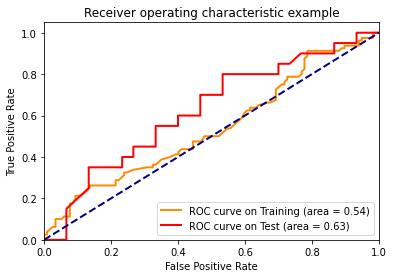

In [43]:
fpr_training, tpr_training, thresholds_training = roc_curve(complete_training_batch_labels, complete_training_batch_predictions, pos_label=1)
fpr_test, tpr_test, thresholds_test = roc_curve(complete_test_batch_labels, complete_test_batch_predictions, pos_label=1)
roc_auc_training = auc(fpr_training, tpr_training)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
lw = 2
plt.plot(fpr_training, tpr_training, color='darkorange',
         lw=lw, label='ROC curve on Training (area = %0.2f)' % roc_auc_training)
plt.plot(fpr_test, tpr_test, color='red',
         lw=lw, label='ROC curve on Test (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")



plt.show()

Non Malignant : f1=0.000 auc=0.480


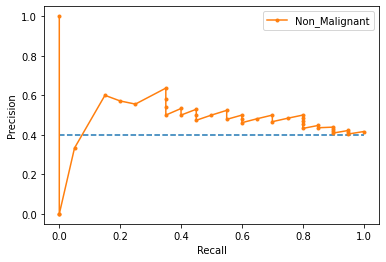

In [45]:
from sklearn.metrics import precision_recall_curve

train_precision, train_recall, _ = precision_recall_curve(complete_training_batch_labels,
                               complete_training_batch_predictions, pos_label=1)
test_precision,test_recall,_ = precision_recall_curve(complete_test_batch_labels, 
                                                complete_test_batch_predictions, pos_label=1)

train_f1,train_auc = f1_score(complete_training_batch_labels,
                               np.round(complete_training_batch_predictions)),auc(train_recall, train_precision)
      
test_f1,test_auc = f1_score(complete_test_batch_labels,
                               np.round(complete_test_batch_predictions)),auc(test_recall, test_precision)


'''precision_recall_training.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))'''

print('Non Malignant : f1=%.3f auc=%.3f' % (test_f1,test_auc))
# plot the precision-recall curves
Malignant = len(complete_test_batch_labels[complete_test_batch_labels==1]) / len(complete_test_batch_labels)
plt.plot([0, 1], [Malignant, Malignant], linestyle='--')
plt.plot(test_recall, test_precision, marker='.', label='Non_Malignant')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()